In [1]:
#this is to auto-reload modules (like utils.py)
%load_ext autoreload
%autoreload 2
    
import os
import time
import sys
from datetime import datetime
from datetime import timedelta
from dateutil import relativedelta

#import warnings


sys.path.append('../') #needed to import utils.py

import utils

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import sklearn as sk

import seaborn as sns
plt.style.use('seaborn-whitegrid')

from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline  


---
## Read data from raw `FVC` CSV file

In [2]:
#set the data directory
data_dir = os.path.abspath('../01_proact_raw_data_2022')

#set the name of CSV file
data_file = f'{data_dir}/PROACT_FVC.csv'

#read data and show some info
df_raw = pd.read_csv(data_file, delimiter=',')

utils.show_columns_stats(df_raw) 

df_raw



subject_id................. = 49110 rows (100.0%)     0 with NaN (  0.0%) Uniques=  9090 
Subject_Liters_Trial_1..... = 45816 rows (93.29%)  3294 with NaN ( 6.71%) Uniques=   686 
pct_of_Normal_Trial_1...... = 18990 rows (38.67%) 30120 with NaN (61.33%) Uniques=  3617 
Subject_Liters_Trial_2..... = 16796 rows ( 34.2%) 32314 with NaN ( 65.8%) Uniques=   647 
pct_of_Normal_Trial_2...... =  9888 rows (20.13%) 39222 with NaN (79.87%) Uniques=  1455 
Subject_Liters_Trial_3..... = 16669 rows (33.94%) 32441 with NaN (66.06%) Uniques=   652 
pct_of_Normal_Trial_3...... =  9811 rows (19.98%) 39299 with NaN (80.02%) Uniques=  1436 
Forced_Vital_Capacity_Delta = 46552 rows (94.79%)  2558 with NaN ( 5.21%) Uniques=   853 
subject_normal............. = 17304 rows (35.24%) 31806 with NaN (64.76%) Uniques=   473 
Forced_Vital_Capacity_Units = 20336 rows (41.41%) 28774 with NaN (58.59%) Uniques=     2 


,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Forced_Vital_Capacity_Delta,subject_normal,Forced_Vital_Capacity_Units
0,89,2.89,NaN,NaN,NaN,NaN,NaN,0.0,3.83,NaN
1,329,2.40,89.0,2.20,NaN,2.37,NaN,247.0,NaN,NaN
2,329,2.71,101.0,2.62,NaN,2.72,NaN,16.0,NaN,NaN
3,329,2.79,104.0,2.62,NaN,2.61,NaN,72.0,NaN,NaN
4,329,2.52,95.0,2.34,NaN,2.54,NaN,189.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
49105,999990,2.39,82.0,2.38,82.0,2.31,79.0,97.0,2.91,NaN
49106,999990,2.57,88.0,2.54,87.0,2.38,82.0,68.0,2.91,NaN
49107,999990,2.47,85.0,2.39,82.0,2.35,81.0,40.0,2.91,NaN
49108,999990,2.70,93.0,2.52,87.0,2.46,85.0,12.0,2.91,NaN


----
----
----
## Check if exist rows with `NaN` on `Forced_Vital_Capacity_Delta` column 
## and, if so, _DELETE_ them
- Note: 2558 rows were deleted 

In [3]:
to_delete = df_raw.loc[(df_raw.Forced_Vital_Capacity_Delta.isnull())]

df_raw = utils.remove_rows(df=df_raw, to_delete=to_delete)



  - Previous=49110, To delete=2558, After=46552


----
----
----
## The value for FVC is present in 3 columns (`Subject_Liters_Trial_1`, `Trial_2`, 
## and `Trial_3`).
## A new column will be created and set to the max value present in these 3 columns.

### Another column will be created to represent the percentage of normal, following the same logic

In [4]:
cols = ['Subject_Liters_Trial_1', 'Subject_Liters_Trial_2', 'Subject_Liters_Trial_3']

# create a new DF with these columns values
df_max_fvc = df_raw[cols].copy()

# replace all NaN values to -1
df_max_fvc.fillna(-1.0, inplace=True)

# get the max value present in columns Subject_Liters_Trial_1, Subject_Liters_Trial_2, and Subject_Liters_Trial_3
df_max_fvc['max'] = df_max_fvc[cols].values.max(axis=1)

#replace -1 values with NaN
df_max_fvc['max'].replace(-1.0, np.NaN, inplace=True)

# create the column FVC in df_raw and set to max value calculated
df_raw['FVC'] = df_max_fvc['max']

df_raw

,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Forced_Vital_Capacity_Delta,subject_normal,Forced_Vital_Capacity_Units,FVC
0,89,2.89,NaN,NaN,NaN,NaN,NaN,0.0,3.83,NaN,2.89
1,329,2.40,89.0,2.20,NaN,2.37,NaN,247.0,NaN,NaN,2.40
2,329,2.71,101.0,2.62,NaN,2.72,NaN,16.0,NaN,NaN,2.72
3,329,2.79,104.0,2.62,NaN,2.61,NaN,72.0,NaN,NaN,2.79
4,329,2.52,95.0,2.34,NaN,2.54,NaN,189.0,NaN,NaN,2.54
...,...,...,...,...,...,...,...,...,...,...,...
49105,999990,2.39,82.0,2.38,82.0,2.31,79.0,97.0,2.91,NaN,2.39
49106,999990,2.57,88.0,2.54,87.0,2.38,82.0,68.0,2.91,NaN,2.57
49107,999990,2.47,85.0,2.39,82.0,2.35,81.0,40.0,2.91,NaN,2.47
49108,999990,2.70,93.0,2.52,87.0,2.46,85.0,12.0,2.91,NaN,2.70


----
----
----
## Another column will be created to represent the percentage of normal, following the same logic of the previous step

## The value is present in 3 columns (`pct_of_Normal_Trial_1`, `Trial_2`, 
## and `Trial_3`).




In [5]:
cols = ['pct_of_Normal_Trial_1', 'pct_of_Normal_Trial_2', 'pct_of_Normal_Trial_3']

# create a new DF with these columns values
df_max_fvc = df_raw[cols].copy()

# replace all NaN values to -1
df_max_fvc.fillna(-1.0, inplace=True)

# get the max value present in columns 
df_max_fvc['max'] = df_max_fvc[cols].values.max(axis=1)

#replace -1 values with NaN
df_max_fvc['max'].replace(-1.0, np.NaN, inplace=True)

df_max_fvc

# create the column FVC in df_raw and set to max value calculated
df_raw['FVC_Perc_of_Normal'] = df_max_fvc['max']

df_raw

,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Forced_Vital_Capacity_Delta,subject_normal,Forced_Vital_Capacity_Units,FVC,FVC_Perc_of_Normal
0,89,2.89,NaN,NaN,NaN,NaN,NaN,0.0,3.83,NaN,2.89,NaN
1,329,2.40,89.0,2.20,NaN,2.37,NaN,247.0,NaN,NaN,2.40,89.0
2,329,2.71,101.0,2.62,NaN,2.72,NaN,16.0,NaN,NaN,2.72,101.0
3,329,2.79,104.0,2.62,NaN,2.61,NaN,72.0,NaN,NaN,2.79,104.0
4,329,2.52,95.0,2.34,NaN,2.54,NaN,189.0,NaN,NaN,2.54,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49105,999990,2.39,82.0,2.38,82.0,2.31,79.0,97.0,2.91,NaN,2.39,82.0
49106,999990,2.57,88.0,2.54,87.0,2.38,82.0,68.0,2.91,NaN,2.57,88.0
49107,999990,2.47,85.0,2.39,82.0,2.35,81.0,40.0,2.91,NaN,2.47,85.0
49108,999990,2.70,93.0,2.52,87.0,2.46,85.0,12.0,2.91,NaN,2.70,93.0


----
----
----
## Check if exist rows with `NaN` on `FVC` column and, if so, _DELETE_ them
- Note: 750 rows were deleted 

In [6]:
to_delete = df_raw.loc[(df_raw.FVC.isnull() == True)]

df_raw = utils.remove_rows(df=df_raw, to_delete=to_delete)


  - Previous=46552, To delete=750, After=45802


----
----
----
## Read Static data and get only columns:
## `subject_id`, and `Symptoms_Onset_Delta`

In [7]:
#set the data directory
data_dir = os.path.abspath('../03_proact_preprocessed/')

#set the name of CSV file
data_file = f'{data_dir}/_patient.csv'

#read data and show some info
df_main = pd.read_csv(data_file, delimiter=',')
df_main.head()


cols = ['subject_id', 'Symptoms_Onset_Delta']

df_main = df_main[cols]
df_main


,subject_id,Symptoms_Onset_Delta
0,329,-1706.0
1,348,-501.0
2,533,-1023.0
3,586,-715.0
4,708,-1070.0
...,...,...
5225,22564,-426.0
5226,160135,-651.0
5227,304192,-838.0
5228,820199,-155.0


## Join the 2 datasets to calcute `FVC Delta` from `Symptoms_Onset`

In [8]:
df_temp = df_raw.copy()
df_temp = utils.join_datasets_by_key(df_main=df_temp, df_to_join=df_main, key_name='subject_id')
df_temp

,subject_id,Subject_Liters_Trial_1,pct_of_Normal_Trial_1,Subject_Liters_Trial_2,pct_of_Normal_Trial_2,Subject_Liters_Trial_3,pct_of_Normal_Trial_3,Forced_Vital_Capacity_Delta,subject_normal,Forced_Vital_Capacity_Units,FVC,FVC_Perc_of_Normal,Symptoms_Onset_Delta
0,89,2.89,NaN,NaN,NaN,NaN,NaN,0.0,3.83,NaN,2.89,NaN,NaN
1,329,2.40,89.0,2.20,NaN,2.37,NaN,247.0,NaN,NaN,2.40,89.0,-1706.0
2,329,2.71,101.0,2.62,NaN,2.72,NaN,16.0,NaN,NaN,2.72,101.0,-1706.0
3,329,2.79,104.0,2.62,NaN,2.61,NaN,72.0,NaN,NaN,2.79,104.0,-1706.0
4,329,2.52,95.0,2.34,NaN,2.54,NaN,189.0,NaN,NaN,2.54,95.0,-1706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49105,999990,2.39,82.0,2.38,82.0,2.31,79.0,97.0,2.91,NaN,2.39,82.0,-331.0
49106,999990,2.57,88.0,2.54,87.0,2.38,82.0,68.0,2.91,NaN,2.57,88.0,-331.0
49107,999990,2.47,85.0,2.39,82.0,2.35,81.0,40.0,2.91,NaN,2.47,85.0,-331.0
49108,999990,2.70,93.0,2.52,87.0,2.46,85.0,12.0,2.91,NaN,2.70,93.0,-331.0


## Create `Delta_from_Symptoms` columns (in ` days` and ` months`)

In [9]:
#calculate in DAYS
df_temp['Delta_from_Symptoms_Onset_in_Days'] = df_temp.Forced_Vital_Capacity_Delta + np.abs(df_temp.Symptoms_Onset_Delta)

#calculate in MONTHS
df_temp['Delta_from_Symptoms_Onset'] = np.NaN
in_months = df_temp['Delta_from_Symptoms_Onset_in_Days'].apply( lambda x: utils.calculate_months_from_days(x)) 
df_temp.loc[df_temp.index,'Delta_from_Symptoms_Onset'] = in_months


df = df_temp

df[['subject_id', 'FVC', 'Forced_Vital_Capacity_Delta', 'Symptoms_Onset_Delta', 'Delta_from_Symptoms_Onset_in_Days', 
         'Delta_from_Symptoms_Onset']]

,subject_id,FVC,Forced_Vital_Capacity_Delta,Symptoms_Onset_Delta,Delta_from_Symptoms_Onset_in_Days,Delta_from_Symptoms_Onset
0,89,2.89,0.0,NaN,NaN,NaN
1,329,2.40,247.0,-1706.0,1953.0,64.0
2,329,2.72,16.0,-1706.0,1722.0,56.0
3,329,2.79,72.0,-1706.0,1778.0,58.0
4,329,2.54,189.0,-1706.0,1895.0,62.0
...,...,...,...,...,...,...
49105,999990,2.39,97.0,-331.0,428.0,14.0
49106,999990,2.57,68.0,-331.0,399.0,13.0
49107,999990,2.47,40.0,-331.0,371.0,12.0
49108,999990,2.70,12.0,-331.0,343.0,11.0


----
----
----
## Calculate percentage of normal for those with FVC_Perc_of_Normal = NaN,
## subject_normal <> NaN and FVC <> NaN	


In [10]:
to_calculate = df.loc[
    (df.FVC_Perc_of_Normal.isnull())
   &(df.subject_normal.isnull() == False)
   &(df.FVC.isnull() == False)
].copy()

df.loc[to_calculate.index, 'FVC_Perc_of_Normal'] = np.round(df['FVC']/df['subject_normal']*100, 0)

display(df.loc[to_calculate.index][['FVC_Perc_of_Normal', 'subject_normal', 'FVC']])

,FVC_Perc_of_Normal,subject_normal,FVC
0,75.0,3.83,2.89
9,83.0,4.43,3.69
10,79.0,3.10,2.44
68,39.0,3.11,1.20
69,111.0,3.90,4.33
...,...,...,...
49029,68.0,4.41,2.98
49030,75.0,4.41,3.29
49031,77.0,4.41,3.39
49094,36.0,3.13,1.14


----
----
----
## Delete some unnecessary columns

In [11]:
cols_to_remove = ['Forced_Vital_Capacity_Delta', 
                  'Subject_Liters_Trial_1', 
                  'pct_of_Normal_Trial_1', 
                  'Subject_Liters_Trial_2', 
                  'pct_of_Normal_Trial_2', 
                  'Subject_Liters_Trial_3', 
                  'pct_of_Normal_Trial_3',
                  'Forced_Vital_Capacity_Units',
                  'Symptoms_Onset_Delta', 
                  'subject_normal',
                  ]

df.drop(
    columns=cols_to_remove, 
    inplace=True
)

utils.show_columns_stats(df) 

subject_id....................... = 45802 rows (100.0%)     0 with NaN (  0.0%) Uniques=  7710 
FVC.............................. = 45802 rows (100.0%)     0 with NaN (  0.0%) Uniques=   686 
FVC_Perc_of_Normal............... = 25617 rows (55.93%) 20185 with NaN (44.07%) Uniques=  1504 
Delta_from_Symptoms_Onset_in_Days = 21282 rows (46.47%) 24520 with NaN (53.53%) Uniques=  2085 
Delta_from_Symptoms_Onset........ = 21282 rows (46.47%) 24520 with NaN (53.53%) Uniques=   134 


----
----
----
## Drop rows with NaN values in the columns Delta_from_Symptoms_Onset and FVC_Perc_of_Normal

In [12]:
df.dropna(subset=['Delta_from_Symptoms_Onset'], inplace=True)

df.dropna(subset=['FVC_Perc_of_Normal'], inplace=True)

display(df)
utils.show_columns_stats(df) 

,subject_id,FVC,FVC_Perc_of_Normal,Delta_from_Symptoms_Onset_in_Days,Delta_from_Symptoms_Onset
1,329,2.40,89.0,1953.0,64.0
2,329,2.72,101.0,1722.0,56.0
3,329,2.79,104.0,1778.0,58.0
4,329,2.54,95.0,1895.0,62.0
5,329,2.75,103.0,1748.0,57.0
...,...,...,...,...,...
49105,999990,2.39,82.0,428.0,14.0
49106,999990,2.57,88.0,399.0,13.0
49107,999990,2.47,85.0,371.0,12.0
49108,999990,2.70,93.0,343.0,11.0


subject_id....................... = 21271 rows (100.0%)     0 with NaN (  0.0%) Uniques=  3563 
FVC.............................. = 21271 rows (100.0%)     0 with NaN (  0.0%) Uniques=   670 
FVC_Perc_of_Normal............... = 21271 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1483 
Delta_from_Symptoms_Onset_in_Days = 21271 rows (100.0%)     0 with NaN (  0.0%) Uniques=  2083 
Delta_from_Symptoms_Onset........ = 21271 rows (100.0%)     0 with NaN (  0.0%) Uniques=   133 


### Solve the problem were rows have duplicated Delta_from_Symptoms_Onset

In [13]:
# sort rows by 'subject_id', 'Delta_from_Symptoms_Onset', and 'Slope'
df_remove_duplicated = df.sort_values(['subject_id', 
                                       'Delta_from_Symptoms_Onset_in_Days', 
                                       'FVC'])

# get only the last row for each 'subject_id' and'Delta_from_Symptoms_Onset'
df_remove_duplicated = df_remove_duplicated.groupby(['subject_id', 
                                                     'Delta_from_Symptoms_Onset'
                                                    ]).last().reset_index()

df = df_remove_duplicated.copy()
df


,subject_id,Delta_from_Symptoms_Onset,FVC,FVC_Perc_of_Normal,Delta_from_Symptoms_Onset_in_Days
0,329,56.0,2.72,101.0,1722.0
1,329,57.0,2.75,103.0,1748.0
2,329,58.0,2.79,104.0,1778.0
3,329,60.0,2.57,103.0,1841.0
4,329,62.0,2.54,95.0,1895.0
...,...,...,...,...,...
19300,999990,11.0,2.70,93.0,343.0
19301,999990,12.0,2.47,85.0,371.0
19302,999990,13.0,2.57,88.0,399.0
19303,999990,14.0,2.39,82.0,428.0


---
---
---
# NOT DONE (see next step)

### Categorize FVC Results according to FVC_Perc_of_Normal
```
 - Normal     >= 80%
 - Abnormal: 
   - Mild     >= 70% and < 80%
   - Moderate >= 60% and < 70%
   - Severe   <  60%
```

Reference: http://www.worker-health.org/breathingtestresults.html

Column: FVC_Result  (DataType: object)
N         = 19329 [Non-NaN: 19329]
Missingness: 0 (0.0%)

Summary Table:
                   count percentage
Normal             10065     52.07%
Abnormal Severe     4065     21.03%
Abnormal Mild       2973     15.38%
Abnormal Moderate   2226     11.52%


/Users/papaiz/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


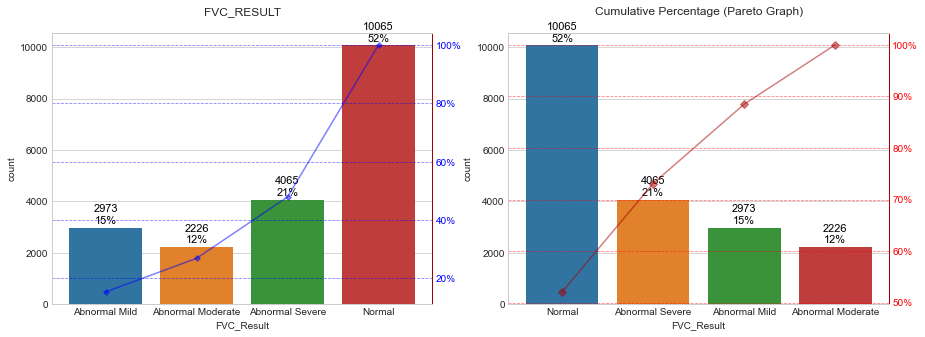

Column: FVC_Result_Coded  (DataType: float64)
N         = 19329 [Non-NaN: 19329]
Missingness: 0 (0.0%)
Min       = 0.00  
Max       = 3.00  
SE / Std  = 1.22  (Standard Error or Std.Dev.)
SEM       = 0.01  (Standard Error of the Mean) [Formula: Std.Dev/sqrt(N) => 1.22/sqrt(19329)] 
Mean      = 1.02 +/- 1.22 (Std.Dev.) [Precision of the Mean = 1.02 +/- 0.01 (SEM)] 
Median    = 0.00  
Mode      = 0.0
Variance  = 1.48 (Coefficient of Variation = 1.20)
Skewness  = 0.67 (Right-Skewed) (Moderately Skewed) 
Kurtosis  = -1.20 (platykurtic, rounded appearance)(PS: a high kurtosis indicates too many outliers) 
Quartiles = [Q1: 25% < 0.00]   [Q2: 50% < 0.00]   [Q3: 75% < 2.00]
 -IQR     = 2.000 (Interquartile Range: IQR = Q3-Q1)
 -Outliers Threshold (IQR * +/-1.5):  [Lower = 0.000]   [Upper = 3.000]


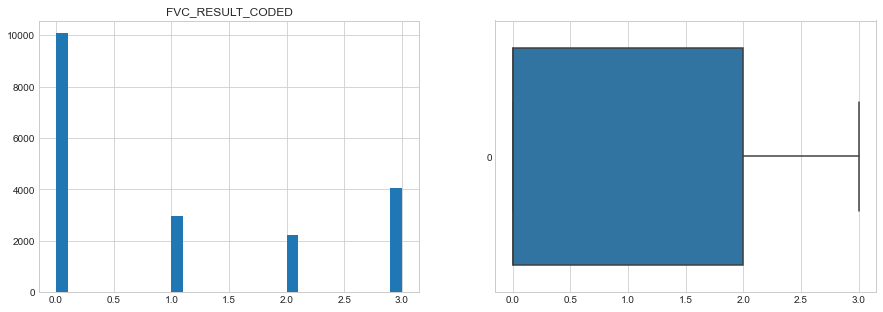

Column: Delta_from_Symptoms_Onset  (DataType: int64)
N         = 19329 [Non-NaN: 19329]
Missingness: 0 (0.0%)
Min       = 0.00  
Max       = 296.00  
SE / Std  = 14.98  (Standard Error or Std.Dev.)
SEM       = 0.11  (Standard Error of the Mean) [Formula: Std.Dev/sqrt(N) => 14.98/sqrt(19329)] 
Mean      = 25.62 +/- 14.98 (Std.Dev.) [Precision of the Mean = 25.62 +/- 0.11 (SEM)] 
Median    = 23.00  
Mode      = 19
Variance  = 224.50 (Coefficient of Variation = 0.58)
Skewness  = 3.60 (Right-Skewed) (Highly Skewed) 
Kurtosis  = 41.88 (leptokurtic, point head appearance)(PS: a high kurtosis indicates too many outliers) 
Quartiles = [Q1: 25% < 16.00]   [Q2: 50% < 23.00]   [Q3: 75% < 32.00]
 -IQR     = 16.000 (Interquartile Range: IQR = Q3-Q1)
 -Outliers Threshold (IQR * +/-1.5):  [Lower = 0.000]   [Upper = 56.000]


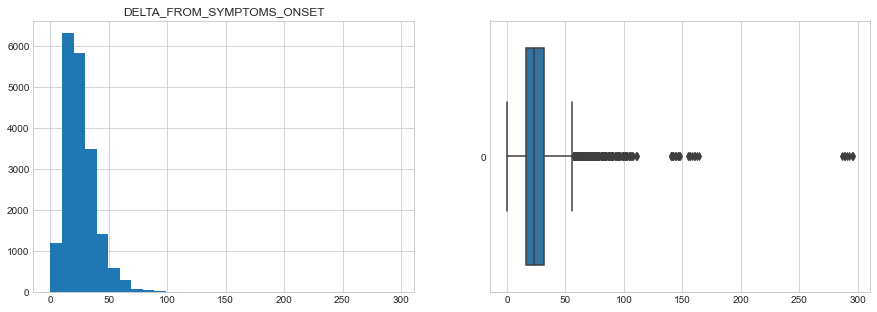

In [14]:
# df_fvc = df.copy()

# # Normal >=80
# to_update = df_fvc.loc[(df_fvc.FVC_Perc_of_Normal >= 80)]
# df_fvc.loc[to_update.index, 'FVC_Result'] = 'Normal'
# df_fvc.loc[to_update.index, 'FVC_Result_Coded'] = 0

# # Abnormal Mild >=70 & <80
# to_update = df_fvc.loc[
#       (df_fvc.FVC_Perc_of_Normal >= 70)
#     & (df_fvc.FVC_Perc_of_Normal <  80)
# ]
# df_fvc.loc[to_update.index, 'FVC_Result'] = 'Abnormal Mild'
# df_fvc.loc[to_update.index, 'FVC_Result_Coded'] = 1

# # Abnormal Moderate >=60 & <70
# to_update = df_fvc.loc[
#       (df_fvc.FVC_Perc_of_Normal >= 60)
#     & (df_fvc.FVC_Perc_of_Normal <  70)
# ]
# df_fvc.loc[to_update.index, 'FVC_Result'] = 'Abnormal Moderate'
# df_fvc.loc[to_update.index, 'FVC_Result_Coded'] = 2

# # Abnormal Severe <60
# to_update = df_fvc.loc[
#       (df_fvc.FVC_Perc_of_Normal < 60)
# ]
# df_fvc.loc[to_update.index, 'FVC_Result'] = 'Abnormal Severe'
# df_fvc.loc[to_update.index, 'FVC_Result_Coded'] = 3




# #calculate Delta_from_Onset in MONTHS
# df_fvc['Delta_from_Symptoms_Onset'] = np.NaN
# in_months = df_fvc['Delta_from_Symptoms_Onset_in_Days'].apply( lambda x: utils.calculate_months_from_days(x)) 
# df_fvc.loc[in_months.index,'Delta_from_Symptoms_Onset'] = in_months


# df_fvc.sort_values(by=['subject_id', 'Delta_from_Symptoms_Onset_in_Days'], inplace=True)


# utils.plot_variables_distributions(
#     df=df_fvc, 
#     columns=[
#         'FVC_Result', 
#         'FVC_Result_Coded',
#         'Delta_from_Symptoms_Onset',
#     ]
# )




---
---
---
### Categorize FVC Results according to FVC_Perc_of_Normal
```
 - Normal     >= 80%   Code: 0
 - Abnormal:   < 80%   Code: 1
```

Reference: http://www.worker-health.org/breathingtestresults.html

In [17]:
df_fvc = df.copy()

# Normal >=80
to_update = df_fvc.loc[(df_fvc.FVC_Perc_of_Normal >= 80)]
df_fvc.loc[to_update.index, 'FVC_Result_Str'] = 'Normal'
df_fvc.loc[to_update.index, 'FVC_Result_Coded'] = 0

# Abnormal <80
to_update = df_fvc.loc[(df_fvc.FVC_Perc_of_Normal <  80)]
df_fvc.loc[to_update.index, 'FVC_Result_Str'] = 'Abnormal'
df_fvc.loc[to_update.index, 'FVC_Result_Coded'] = 1




Column: FVC_Result_Str  (DataType: object)
N         = 19305 [Non-NaN: 19305]
Missingness: 0 (0.0%)

Summary Table:
          count percentage
Normal    10057     52.10%
Abnormal   9248     47.90%


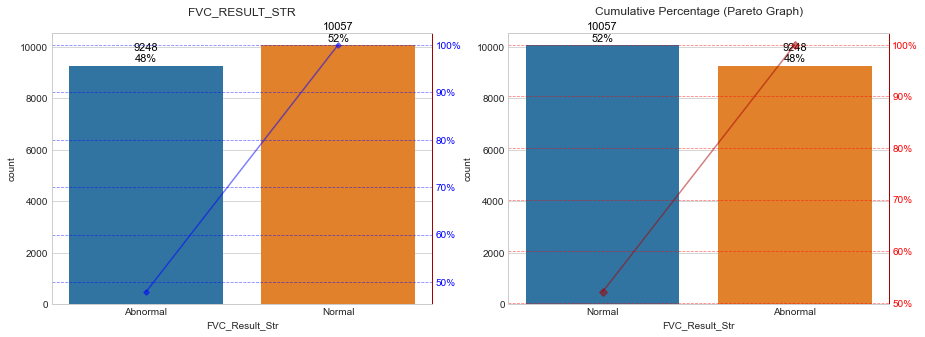

Column: FVC_Result_Coded  (DataType: float64)
N         = 19305 [Non-NaN: 19305]
Missingness: 0 (0.0%)
Min       = 0.00  
Max       = 1.00  
SE / Std  = 0.50  (Standard Error or Std.Dev.)
SEM       = 0.00  (Standard Error of the Mean) [Formula: Std.Dev/sqrt(N) => 0.50/sqrt(19305)] 
Mean      = 0.48 +/- 0.50 (Std.Dev.) [Precision of the Mean = 0.48 +/- 0.00 (SEM)] 
Median    = 0.00  
Mode      = 0.0
Variance  = 0.25 (Coefficient of Variation = 1.04)
Skewness  = 0.08 (Right-Skewed) (Approximately Symmetric) 
Kurtosis  = -1.99 (platykurtic, rounded appearance)(PS: a high kurtosis indicates too many outliers) 
Quartiles = [Q1: 25% < 0.00]   [Q2: 50% < 0.00]   [Q3: 75% < 1.00]
 -IQR     = 1.000 (Interquartile Range: IQR = Q3-Q1)
 -Outliers Threshold (IQR * +/-1.5):  [Lower = 0.000]   [Upper = 1.000]


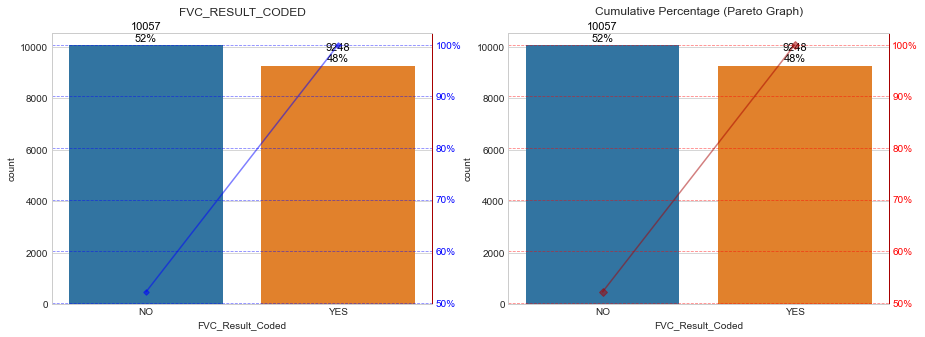

Column: Delta_from_Symptoms_Onset  (DataType: float64)
N         = 19305 [Non-NaN: 19305]
Missingness: 0 (0.0%)
Min       = 0.00  
Max       = 296.00  
SE / Std  = 14.99  (Standard Error or Std.Dev.)
SEM       = 0.11  (Standard Error of the Mean) [Formula: Std.Dev/sqrt(N) => 14.99/sqrt(19305)] 
Mean      = 25.63 +/- 14.99 (Std.Dev.) [Precision of the Mean = 25.63 +/- 0.11 (SEM)] 
Median    = 23.00  
Mode      = 19.0
Variance  = 224.64 (Coefficient of Variation = 0.58)
Skewness  = 3.60 (Right-Skewed) (Highly Skewed) 
Kurtosis  = 41.87 (leptokurtic, point head appearance)(PS: a high kurtosis indicates too many outliers) 
Quartiles = [Q1: 25% < 16.00]   [Q2: 50% < 23.00]   [Q3: 75% < 32.00]
 -IQR     = 16.000 (Interquartile Range: IQR = Q3-Q1)
 -Outliers Threshold (IQR * +/-1.5):  [Lower = 0.000]   [Upper = 56.000]


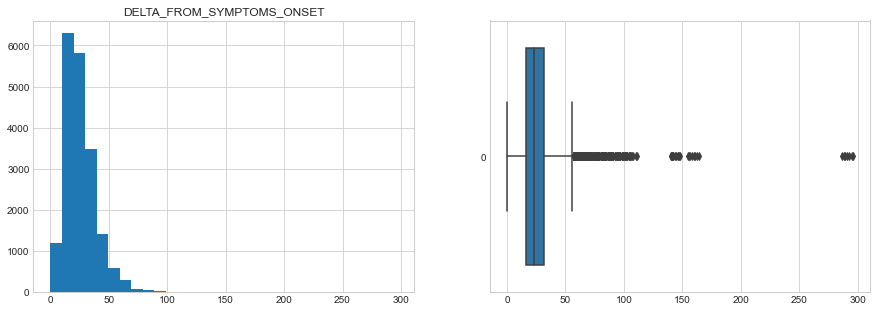

In [18]:
utils.plot_variables_distributions(
    df=df_fvc, 
    columns=[
        'FVC_Result_Str', 
        'FVC_Result_Coded',
        'Delta_from_Symptoms_Onset',
    ]
)


In [19]:
utils.show_columns_stats(df_fvc)

subject_id....................... = 19305 rows (100.0%)     0 with NaN (  0.0%) Uniques=  3563 
Delta_from_Symptoms_Onset........ = 19305 rows (100.0%)     0 with NaN (  0.0%) Uniques=   133 
FVC.............................. = 19305 rows (100.0%)     0 with NaN (  0.0%) Uniques=   665 
FVC_Perc_of_Normal............... = 19305 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1399 
Delta_from_Symptoms_Onset_in_Days = 19305 rows (100.0%)     0 with NaN (  0.0%) Uniques=  2040 
FVC_Result_Str................... = 19305 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 
FVC_Result_Coded................. = 19305 rows (100.0%)     0 with NaN (  0.0%) Uniques=     2 


----
----
----
# Save the pre-processed data to CSV file

In [20]:
dir_dest = os.path.abspath('../03_proact_preprocessed/')

# save CSv file
csv_dest = f'{dir_dest}/_FVC.csv'
utils.save_to_csv(df=df_fvc, csv_file=csv_dest)


19305 samples were saved


----
----
----
---
---
# Generate Time-Series from Symptoms-Onset for each patient

In [21]:
# Get values by month up to 72 months (i.e., 6 years)
n_years = 10
threshold = 12 * n_years # "n" years
months = np.linspace(0, threshold, threshold+1, dtype=float) #[1.0, 2.0, 3.0,..., 72.0]


baselines = ['Symptoms_Onset']

dir_dest = os.path.abspath('../03_proact_preprocessed/')

for baseline in baselines:

    col_baseline = f'Delta_from_{baseline}'
    
    # copy data ordering by col_baseline
    df_copy = df_fvc.sort_values(by=['subject_id', col_baseline]).copy()
    
    # drop rows with NaN in col_baseline
    df_copy.dropna(
        subset=[
            col_baseline, 
            'FVC_Perc_of_Normal', 
            'FVC_Result_Coded'
        ], 
        inplace=True
    )

    # filter rows by threshold
    df_pivot = df_copy.copy()

    # get only the names of the Values columns 
    cols_to_pivot = df_pivot.columns[2:]

    # create pivot by column Result
    df_aux = df_pivot.pivot_table(
        index='subject_id', 
        columns=col_baseline, 
        values='FVC_Result_Coded',
        aggfunc=np.max, # get max value in that month (can exist 2+ measurements for a same month)
    )
    
    # reset index
    df_aux.reset_index(inplace=True)

    # get the month-columns existing in the pivot-table
    cols_months = df_aux.columns[1:]

    # check if all months columns were created [1-72]
    for month in months:
        # if month not present in the columns
        if month not in cols_months:
            # Creating column for this month and set its values to NaN
            # PS: "int(month)" is used to keep columns ordered by month number
            df_aux.insert(int(month), month, np.NaN)

    # code to ensure the order of the columns
    cols_months_ordered = list(sorted(months))
    cols_months_ordered.insert(0, 'subject_id')
    df_aux = df_aux[cols_months_ordered]
            
    # set month-0 = 0 (normal group)
    df_aux[0.0] = 0
            
    # save data for each Value column
    print(f'{col_baseline}')
    csv_file = f'{dir_dest}/TimeSeries/without_MI/FVC_TimeSeries_from_{baseline}.csv'
    utils.save_to_csv(df=df_aux, csv_file=csv_file)


    # read file saved to fill NaN values using interpolation
    df_fill_nan_using_interpolation = pd.read_csv(csv_file, delimiter=',')
    # get columns ignoring 'subject_id'
    cols_months = df_fill_nan_using_interpolation.columns[1:]

    # print (cols_months)
    df_aux = df_fill_nan_using_interpolation[cols_months].interpolate(
        method='linear', 
        limit_direction='both',
        limit=1000, 
        axis=1, 
        inplace=False,
    ).copy()

    # round Values using 0 decimal places
    df_aux[cols_months] = np.round(df_aux[cols_months], 0)

    # get subject_id column
    df_fill_nan_using_interpolation[cols_months] = df_aux[cols_months]

    # drop rows with NaN values (where there is no Value registered)
    df_fill_nan_using_interpolation.dropna(inplace=True)

    # save data again for each Value column with interpolation
    print(f'{col_baseline} with_Missing_Imputation')
    csv_file = f'{dir_dest}/TimeSeries/FVC_TimeSeries_from_{baseline}_with_MI.csv'
    utils.save_to_csv(df=df_fill_nan_using_interpolation, csv_file=csv_file)

    # just for further tests
    df_aux = df_fill_nan_using_interpolation.copy()
    
    print()



Delta_from_Symptoms_Onset
3563 samples were saved
Delta_from_Symptoms_Onset with_Missing_Imputation
3563 samples were saved



### ######################################################################################
### ######################################################################################
### ######################################################################################

